# Fall 2025 Launch 

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import datetime

plt.rcParams.update({
    "figure.facecolor": (1,1,1,1),
    "axes.facecolor": (1,1,1,1),
    "savefig.facecolor": (1,1,1,1),
})

In [2]:
# get data
df = pd.read_csv(os.path.join("data", "merged_output.csv"), skiprows=range(1,49))

graph_folder = "Fall2025Graphs"

In [3]:
display(df.head())

print(df.columns)


,Millis,INA260 Current (mA),INA260 Voltage (mV),INA260 Power (mW),PicoTemp Temp (C),MTK3339 Year,MTK3339 Month,MTK3339 Day,MTK3339 Hour,MTK3339 Minute,...,ENS160_O TVOC (ppb),ENS160_O eCO2 (ppm),BMP390_O Temp (C),BMP390_O Pressure (Pa),BMP390_O Altitude (m),TMP117_O Temp_O (C),SHTC3_O Temp (C),SHTC3_O Rel Hum (%),Ozone Conc (ppb),Analog_Temp_0 ADC_val
0,22636,940.00,3390.00,3190.0,17.307579,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.15,55.700001,NaN,670.0
1,23169,NaN,NaN,NaN,NaN,2025.0,12.0,6.0,17.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12.16,55.610001,NaN,676.0
2,24518,923.75,3358.75,3120.0,16.839434,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.16,55.540001,NaN,675.0
3,25050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.15,55.439999,NaN,670.0
4,25581,698.75,3492.50,2440.0,16.839434,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.19,55.400002,NaN,667.0


Index(['Millis', 'INA260 Current (mA)', 'INA260 Voltage (mV)',
       'INA260 Power (mW)', 'PicoTemp Temp (C)', 'MTK3339 Year',
       'MTK3339 Month', 'MTK3339 Day', 'MTK3339 Hour', 'MTK3339 Minute',
       'MTK3339 Second', 'MTK3339 Latitude', 'MTK3339 Longitude',
       'MTK3339 Speed', 'MTK3339 Heading', 'MTK3339 Altitude',
       'MTK3339 Satellites', 'ICM20948 AccX (g)', 'ICM20948 AccY (g)',
       'ICM20948 AccZ (g)', 'ICM20948 GyroX (deg/s)', 'ICM20948 GyroY (deg/s)',
       'ICM20948 GyroZ (deg/s)', 'ICM20948 MagX (uT)', 'ICM20948 MagY (uT)',
       'ICM20948 MagZ (uT)', 'ICM20948 Temp (C)', 'PCF8523 Year',
       'PCF8523 Month', 'PCF8523 Day', 'PCF8523 Hour', 'PCF8523 Minute',
       'PCF8523 Second', 'TMP117 Temp (C)', 'UV_Sensor_O UVA2 (nm)',
       'UV_Sensor_O UVB2 (nm)', 'UV_Sensor_O UVC2 (nm)', 'ENS160_O AQI',
       'ENS160_O TVOC (ppb)', 'ENS160_O eCO2 (ppm)', 'BMP390_O Temp (C)',
       'BMP390_O Pressure (Pa)', 'BMP390_O Altitude (m)',
       'TMP117_O Temp_O (C)',

In [10]:
print(df["Millis"].count())
timestamps = []
last_time = None
last_millis = 0
for i in range(len(df)):
    if (np.isnan(df["MTK3339 Year"][i]) or df["MTK3339 Year"][i] != 2025) and last_time == None:
        timestamps.append(pd.NaT)
    elif (np.isnan(df["MTK3339 Year"][i]) or df["MTK3339 Year"][i] != 2025):
        if df["Millis"][i] < last_millis: 
            timestamps.append(pd.NaT)
        else: 
            # exptrapolate time 
            timestamps.append(last_time + pd.Timedelta(milliseconds=(df["Millis"][i] - last_millis)))
    else:
        # build timestamp 
        # class pandas.Timestamp(ts_input=<object object>, year=None, month=None, day=None, hour=None, minute=None, 
        # second=None, microsecond=None, tzinfo=None, *, nanosecond=None, tz=None, unit=None, fold=None)
        stamp = pd.Timestamp(year=int(df["MTK3339 Year"][i]), 
                                       month=int(df["MTK3339 Month"][i]),
                                       day=int(df["MTK3339 Day"][i]),
                                       hour=int(df["MTK3339 Hour"][i]),
                                       minute=int(df["MTK3339 Minute"][i]),
                                       second=int(df["MTK3339 Second"][i]),
                                       tz="UTC"
                                      )
        last_time = stamp
        last_millis = df["Millis"][i]
        timestamps.append(stamp)

df["Timestamp"] = timestamps
print(df["Timestamp"].dtype)
df["Timestamp"] = df["Timestamp"].dt.tz_convert('MST')
display(df["Timestamp"].head())

df["Accel Magnitude (g)"] = [math.sqrt((df['ICM20948 AccX (g)'][i]**2) + (df['ICM20948 AccY (g)'][i]**2) + (df['ICM20948 AccZ (g)'][i]**2)) for i in range(len(df))]

R = 10_000 # 10kOhms 
A = 1.130801397e-03
B = 2.338433402e-04
C = 0.8887342465e-07
# # R2 = R1 * (1023.0 / (float)Vo – 1.0);

def adc_to_temp(adc): 
    v = 3.3 * (adc / 1023) 
    Rt = R * (v / (3.3 - v)) # lower 
    # upper Rt = R * (Vin / Vout = 1) 
    Rt_log = math.log(Rt) 
    T = 1 / (A + B * Rt_log + C * Rt_log**3)
    return T - 273.15

df["Temp_O (C)"] = df['Analog_Temp_0 ADC_val'].apply(adc_to_temp)

df["GPS Alt (m)"] = df['MTK3339 Altitude'] / 1000

clean_df = df.dropna(subset=["Timestamp"])
display(clean_df["Timestamp"].head())


10922
datetime64[ns, UTC]


0                                NaT
1          2025-12-06 10:01:58-07:00
2   2025-12-06 10:01:59.349000-07:00
3   2025-12-06 10:01:59.881000-07:00
4   2025-12-06 10:02:00.412000-07:00
Name: Timestamp, dtype: datetime64[ns, MST]

1          2025-12-06 10:01:58-07:00
2   2025-12-06 10:01:59.349000-07:00
3   2025-12-06 10:01:59.881000-07:00
4   2025-12-06 10:02:00.412000-07:00
5          2025-12-06 10:02:01-07:00
Name: Timestamp, dtype: datetime64[ns, MST]

2673
10684 datetime64[ns, MST]


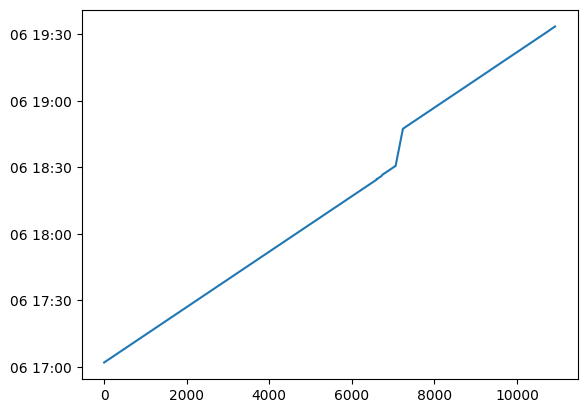

In [8]:
print(clean_df["GPS Alt (m)"].count())
print(clean_df["Timestamp"].count(), clean_df["Timestamp"].dtype)
clean_df["Timestamp"].plot.line()

plt.show()

INA260 Current (mA)


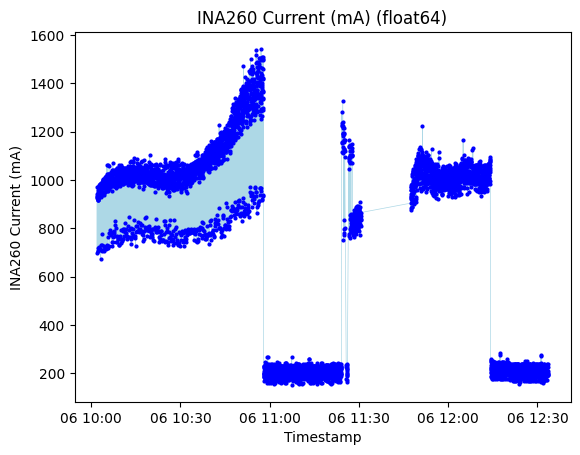

INA260 Voltage (mV)


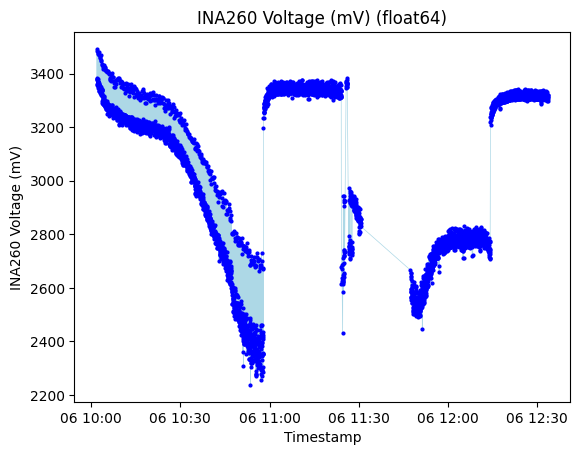

INA260 Power (mW)


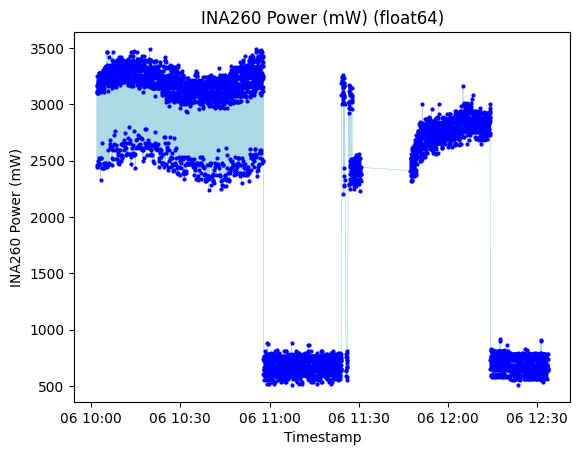

PicoTemp Temp (C)


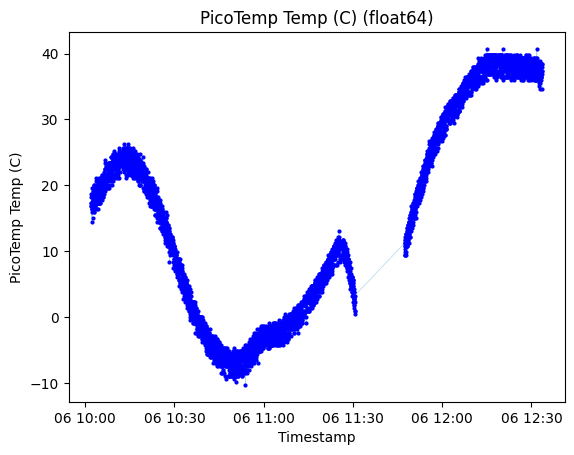

Accel Magnitude (g)


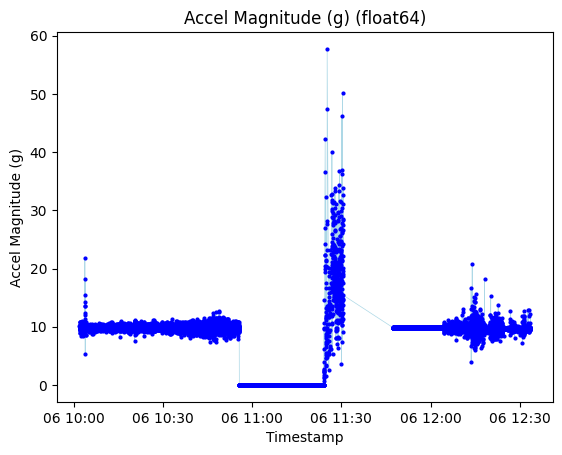

ENS160_O AQI


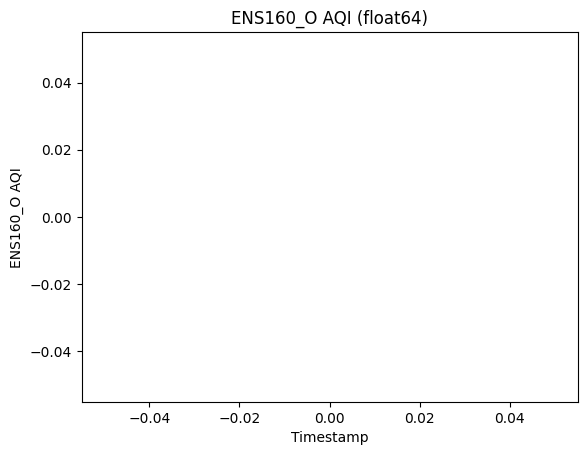

ENS160_O TVOC (ppb)


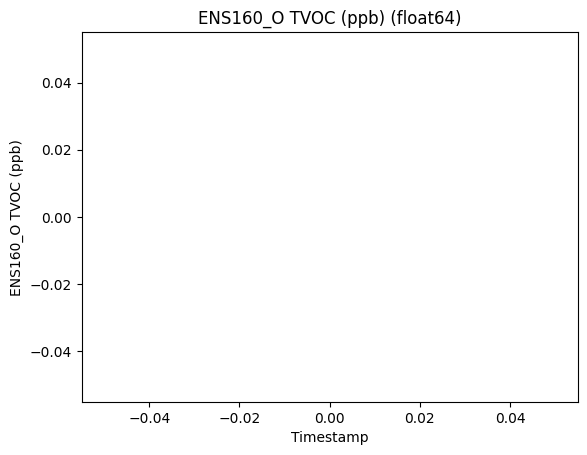

ENS160_O eCO2 (ppm)


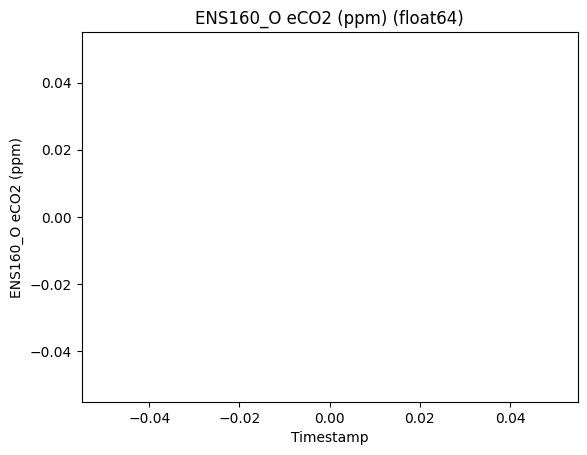

SHTC3_O Temp (C)


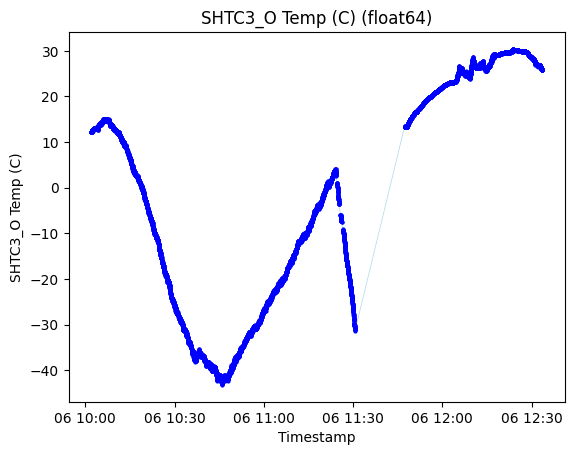

SHTC3_O Rel Hum (%)


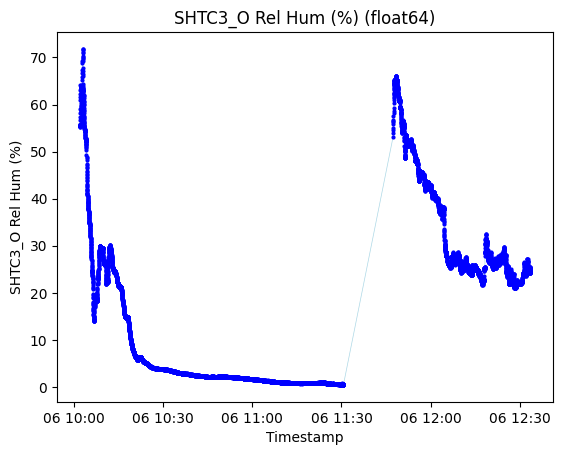

Ozone Conc (ppb)


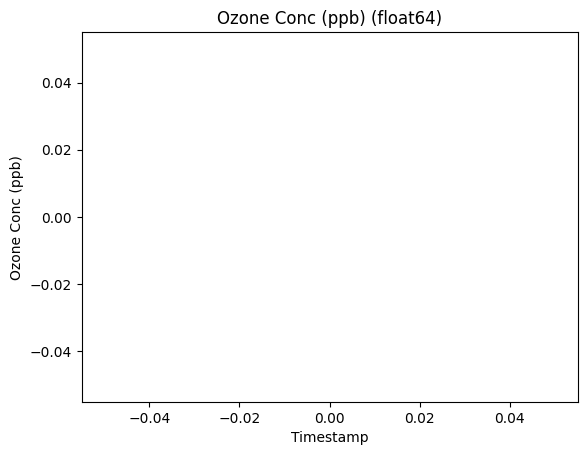

Temp_O (C)


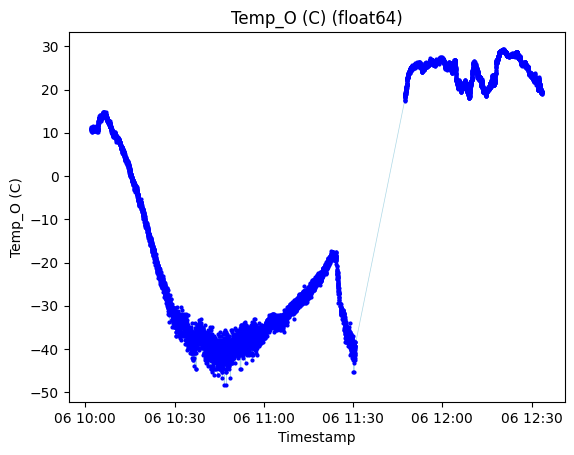

GPS Alt (m)


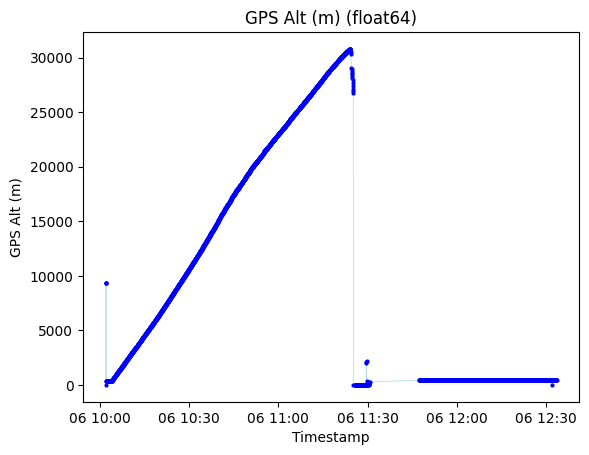

MTK3339 Speed


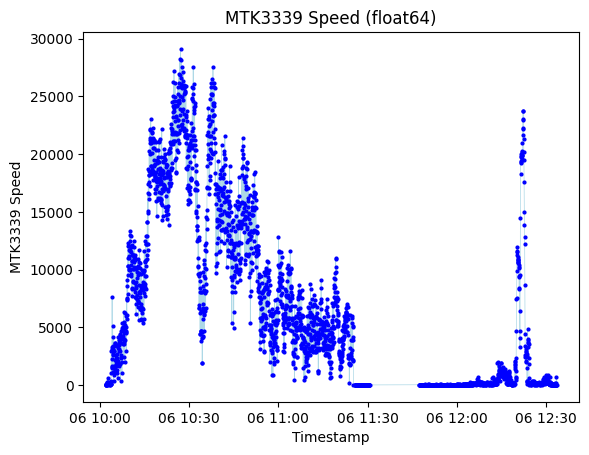

In [30]:
target_cols = [
    "INA260 Current (mA)",
    "INA260 Voltage (mV)", 
    "INA260 Power (mW)", 
    "PicoTemp Temp (C)", 
    "Accel Magnitude (g)", 
    "ENS160_O AQI", 
    "ENS160_O TVOC (ppb)",
    "ENS160_O eCO2 (ppm)",
    "SHTC3_O Temp (C)", 
    "SHTC3_O Rel Hum (%)", 
    "Ozone Conc (ppb)", 
    "Temp_O (C)", 
    "GPS Alt (m)", 
    "MTK3339 Speed"
]
for col in target_cols: 
    print(col, )
    mask = clean_df[col].notna()
    x = clean_df.loc[mask, "Timestamp"] 
    y = clean_df.loc[mask, col] 
    plt.plot(x, y, linewidth=0.5, marker='o', markersize=2, markerfacecolor="blue", markeredgecolor="blue", color="lightblue") 
    plt.title(col + f" ({df[col].dtype})")
    plt.ylabel(col)
    plt.xlabel("Timestamp")

    plt.savefig(os.path.join("Fall2025Graphs", f"{col}_vs_time.png"))
    
    plt.show()